In [3]:
import ibis
from ibis import _
import polars as pl
from polars import col
import ray
import numpy as np
from plotnine import geom_point, ggplot, aes, geom_density, geom_bar

from rl4eco.utils import simulate, load_hf_agent
from rl4fisheries import Asm, Asm2o

In [4]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = effort[0]

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        action = np.array([action], dtype=np.float32)
        return action, {}

msy_agent = fixed_effort([0.063])

In [5]:
env = Asm()
ppo_agent = load_hf_agent("PPO", env,  "sb3/PPO-Asm-v0-1.zip")

In [7]:
env = Asm2o()

ppo2o_agent = load_hf_agent("PPO", env,  "sb3/PPO-Asm2o-v0-1.zip")

PPO-Asm2o-v0-1.zip:   0%|          | 0.00/140k [00:00<?, ?B/s]

In [20]:
env = Asm2o()
env.reset()
env.step(-1)

(array([-0.7795637 , -0.04880557], dtype=float32), 0.0, False, False, {})

In [8]:
class simulator:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    def simulate(self, reps=10):
        results = []
        env = self.env
        agent = self.agent
        for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
            episode_reward = 0.0
            observation, _ = env.reset()
            for t in range(env.Tmax):
                action, _ = agent.predict(observation, deterministic=True)
                observation, reward, terminated, done, info = env.step(action)
                episode_reward += reward
                if terminated or done:
                    break
            results.append(episode_reward)      
        return results


In [12]:
ppo_sims = simulator(Asm(), ppo_agent).simulate(100)
np.mean(ppo_sims), np.std(ppo_sims)

(48.91128019988916, 14.104269749142052)

In [9]:
ppo2o_sims = simulator(Asm2o(), ppo2o_agent).simulate(100)
np.mean(ppo2o_sims), np.std(ppo2o_sims)

(68.51222554719878, 16.764354999927725)

In [11]:
msy_sims = simulator(Asm(), msy_agent).simulate(100)
np.mean(msy_sims), np.std(msy_sims)

(43.60841585191602, 13.59653923663317)

In [13]:
df_msy = pl.from_records(msy_sims, "x").with_columns(pl.lit("msy").alias("model"))
df_ppo = pl.from_records(ppo_sims, "x").with_columns(pl.lit("ppo").alias("model"))
df_ppo2o = pl.from_records(ppo2o_sims, "x").with_columns(pl.lit("ppo2o").alias("model"))


df = df_msy.extend(df_ppo).extend(df_ppo2o)

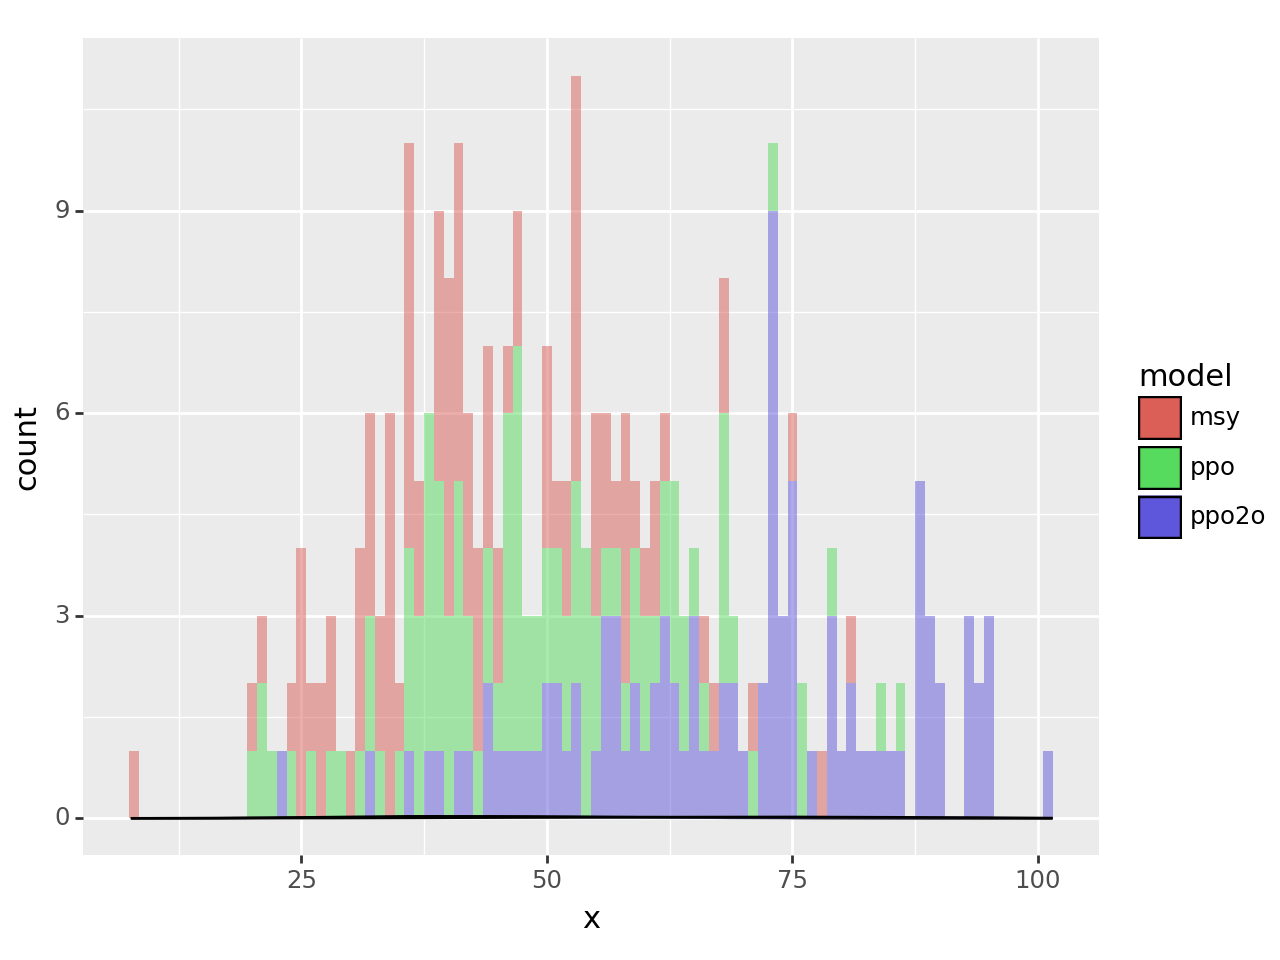

<Figure Size: (640 x 480)>

In [14]:
ggplot(df, aes("x", fill="model")) + geom_bar(stat="bin", binwidth=1, alpha=0.5) + geom_density() 

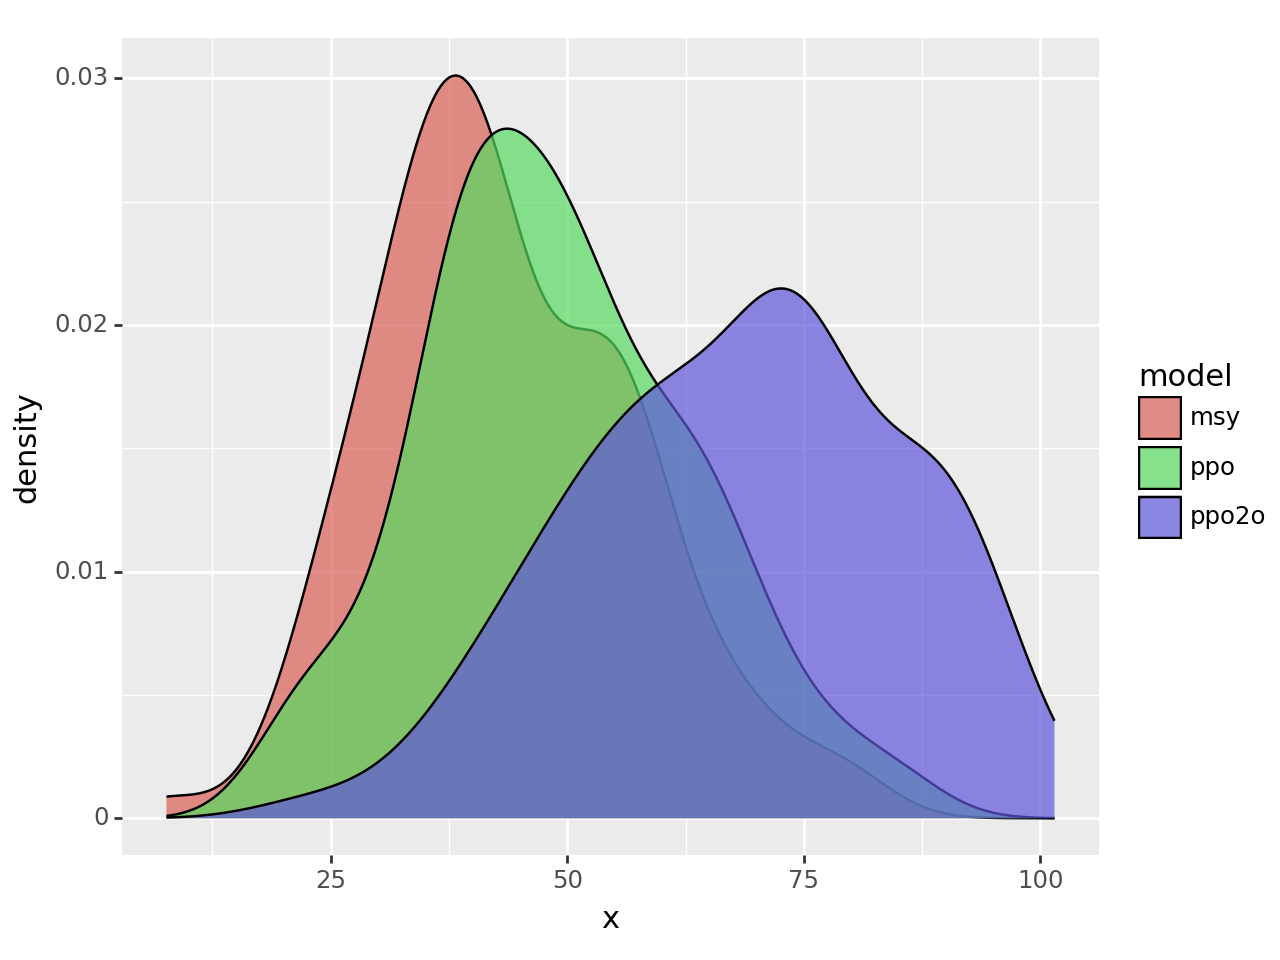

<Figure Size: (640 x 480)>

In [15]:
ggplot(df, aes("x", fill="model")) + geom_density(alpha=0.7) 

In a one-dimensional observation space we can easily  visualize the policy as a function of the state

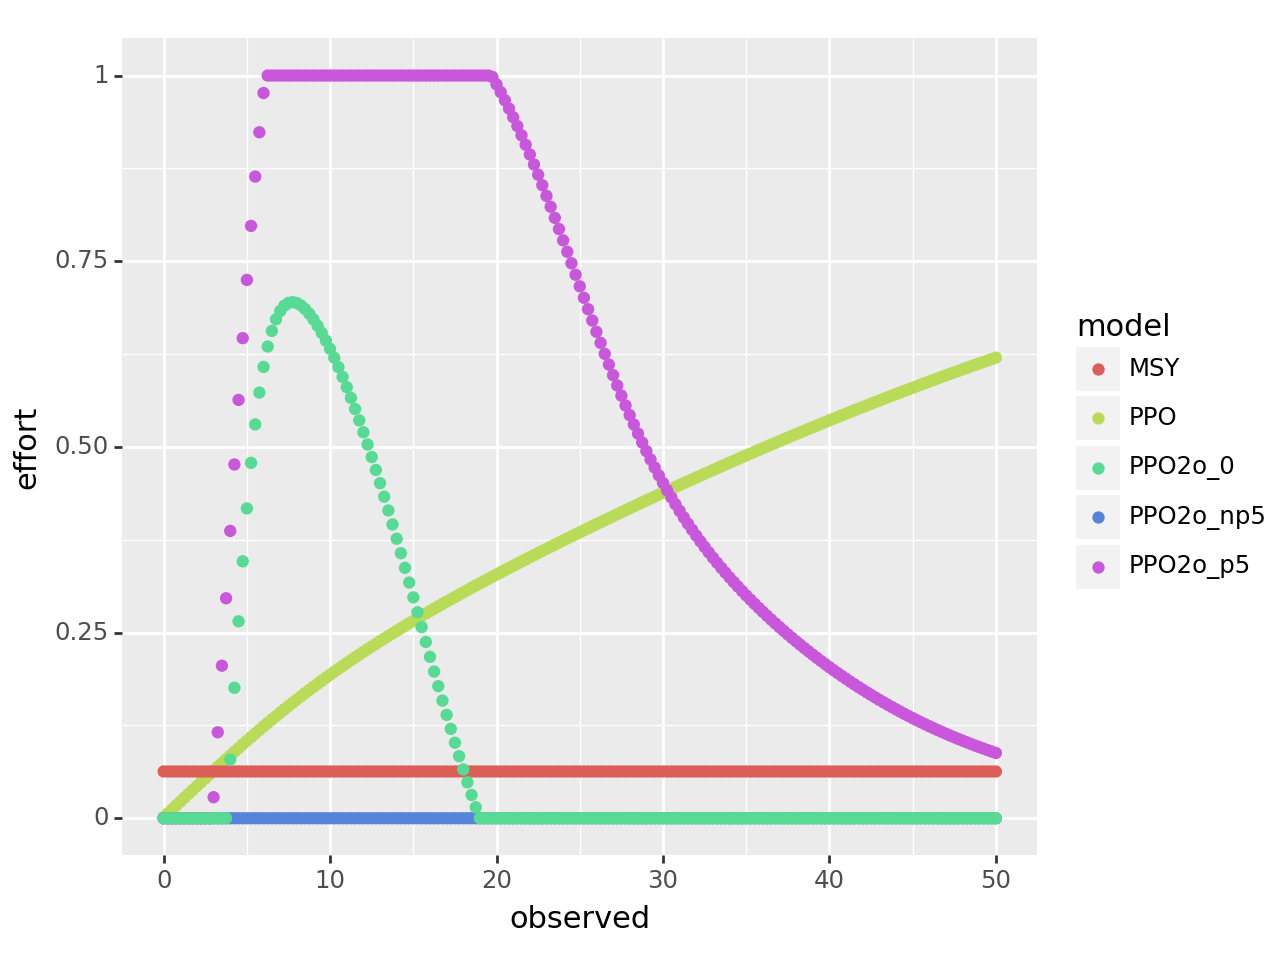

<Figure Size: (640 x 480)>

In [19]:
df = []
observed = np.linspace(-1,1,201)

for obs in observed:
    action, _ = ppo_agent.predict(np.array([obs]), deterministic=True)
    df.append([obs, action, "PPO"])


for obs in observed:
    action, _ = msy_agent.predict(np.array([obs]), deterministic=True)
    df.append([obs, action, "MSY"])



# well it depends...
for obs in observed:
    action, _ = ppo2o_agent.predict(np.array([obs,-0.5]), deterministic=True)
    df.append([obs, action, "PPO2o_np5"])
for obs in observed:
    action, _ = ppo2o_agent.predict(np.array([obs,0.5]), deterministic=True)
    df.append([obs, action, "PPO2o_p5"])    
for obs in observed:
    action, _ = ppo2o_agent.predict(np.array([obs,0]), deterministic=True)
    df.append([obs, action, "PPO2o_0"])

df = pl.DataFrame(df, schema=['obs', 'action', 'model'])

df2 = (df.
       with_columns(observed = (col('obs') + 1) * env.bound / 2).
       with_columns(effort = (col('action') + 1) / 2).
       with_columns(escapement = col('observed') * (1. - col('effort')))
      )
df2

ggplot(df2, aes("observed", "effort", color="model")) + geom_point()